In [0]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 1.x
except Exception:
  pass

!pip install -U tensorboard >piplog 2>&1

TensorFlow 1.x selected.


In [0]:
import tensorflow as tf
import datetime

In [0]:
# import the necessary packages
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras import backend as K
class MiniVGGNet:
	@staticmethod
	def build(width, height, depth, classes):
		# initialize the model along with the input shape to be
		# "channels last" and the channels dimension itself
		model = Sequential()
		inputShape = (height, width, depth)
		chanDim = -1
		# if we are using "channels first", update the input shape
		# and channels dimension
		if K.image_data_format() == "channels_first":
			inputShape = (depth, height, width)
			chanDim = 1
        # first CONV => RELU => CONV => RELU => POOL layer set
		model.add(Conv2D(32, (3, 3), padding="same",
			input_shape=inputShape))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(Conv2D(32, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(MaxPooling2D(pool_size=(2, 2)))
		model.add(Dropout(0.25))
		# second CONV => RELU => CONV => RELU => POOL layer set
		model.add(Conv2D(64, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(Conv2D(64, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(MaxPooling2D(pool_size=(2, 2)))
		model.add(Dropout(0.25))
		# first (and only) set of FC => RELU layers
		model.add(Flatten())
		model.add(Dense(512))
		model.add(Activation("relu"))
		model.add(BatchNormalization())
		model.add(Dropout(0.5))
		# softmax classifier
		model.add(Dense(classes))
		model.add(Activation("softmax"))
		# return the constructed network architecture
		return model

Using TensorFlow backend.


### Train a simple model and create TensorBoard logs

In [0]:
# set the matplotlib backend so figures can be saved in the background
import cv2
import numpy as np
import matplotlib.pyplot as plt
from imutils import build_montages
from keras import backend as K
from keras.utils import np_utils
from keras.datasets import fashion_mnist
from keras.optimizers import SGD
from sklearn.metrics import classification_report
import matplotlib
matplotlib.use("Agg")
# import the necessary packages
# initialize the number of epochs to train for, base learning rate,
# and batch size
NUM_EPOCHS = 2
INIT_LR = 1e-2
BS = 32

In [0]:

# grab the Fashion MNIST dataset (if this is your first time running
# this the dataset will be automatically downloaded)
print("[INFO] loading Fashion MNIST...")
((trainX, trainY), (testX, testY)) = fashion_mnist.load_data()
# if we are using "channels first" ordering, then reshape the design
# matrix such that the matrix is:
# 	num_samples x depth x rows x columns
if K.image_data_format() == "channels_first":
	trainX = trainX.reshape((trainX.shape[0], 1, 28, 28))
	testX = testX.reshape((testX.shape[0], 1, 28, 28))
 
# otherwise, we are using "channels last" ordering, so the design
# matrix shape should be: num_samples x rows x columns x depth
else:
	trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
	testX = testX.reshape((testX.shape[0], 28, 28, 1))

[INFO] loading Fashion MNIST...


In [0]:


# scale data to the range of [0, 1]
trainX = trainX.astype("float32") / 255.0
testX = testX.astype("float32") / 255.0
# one-hot encode the training and testing labels
trainY = np_utils.to_categorical(trainY, 10)
testY = np_utils.to_categorical(testY, 10)
# initialize the label names
labelNames = ["top", "trouser", "pullover", "dress", "coat",
	"sandal", "shirt", "sneaker", "bag", "ankle boot"]

# initialize the optimizer and model
print("[INFO] compiling model...")
opt = SGD(lr=INIT_LR, momentum=0.9, decay=INIT_LR / NUM_EPOCHS)
model = MiniVGGNet.build(width=28, height=28, depth=1, classes=10)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])
# train the network

log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

print("[INFO] training model...")
H = model.fit(trainX, trainY,
	validation_data=(testX, testY),
	batch_size=BS, epochs=NUM_EPOCHS)

[INFO] compiling model...












Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


[INFO] training model...
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 60000 samples, validate on 10000 samples
Epoch 1/2
60000/60000 [==============================] - 376s 6ms/step - loss: 0.5037 - acc: 0.8283 - val_loss: 0.3207 - val_acc: 0.8857
Epoch 2/2
60000/60000 [==============================] - 372s 6ms/step - loss: 0.3617 - acc: 0.8713 - val_loss: 0.3008 - val_acc: 0.8938


In [0]:
# make predictions on the test set
preds = model.predict(testX)
# show a nicely formatted classification report
print("[INFO] evaluating network...")
print(classification_report(testY.argmax(axis=1), preds.argmax(axis=1),
	target_names=labelNames))
# plot the training loss and accuracy
N = NUM_EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")

[INFO] evaluating network...
              precision    recall  f1-score   support

         top       0.86      0.83      0.85      1000
     trouser       0.99      0.97      0.98      1000
    pullover       0.88      0.80      0.84      1000
       dress       0.89      0.90      0.90      1000
        coat       0.78      0.88      0.83      1000
      sandal       0.99      0.96      0.98      1000
       shirt       0.69      0.69      0.69      1000
     sneaker       0.92      0.99      0.95      1000
         bag       0.97      0.97      0.97      1000
  ankle boot       0.99      0.94      0.96      1000

    accuracy                           0.89     10000
   macro avg       0.90      0.89      0.89     10000
weighted avg       0.90      0.89      0.89     10000



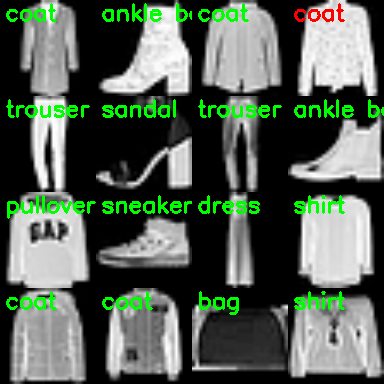

-1

In [0]:
from google.colab.patches import cv2_imshow
# initialize our list of output images
images = []
# randomly select a few testing fashion items
for i in np.random.choice(np.arange(0, len(testY)), size=(16,)):
	# classify the clothing
	probs = model.predict(testX[np.newaxis, i])
	prediction = probs.argmax(axis=1)
	label = labelNames[prediction[0]]
 
	# extract the image from the testData if using "channels_first"
	# ordering
	if K.image_data_format() == "channels_first":
		image = (testX[i][0] * 255).astype("uint8")
 
	# otherwise we are using "channels_last" ordering
	else:
		image = (testX[i] * 255).astype("uint8")
  	# initialize the text label color as green (correct)
	color = (0, 255, 0)
	# otherwise, the class label prediction is incorrect
	if prediction[0] != np.argmax(testY[i]):
		color = (0, 0, 255)
 
	# merge the channels into one image and resize the image from
	# 28x28 to 96x96 so we can better see it and then draw the
	# predicted label on the image
	image = cv2.merge([image] * 3)
	image = cv2.resize(image, (96, 96), interpolation=cv2.INTER_LINEAR)
	cv2.putText(image, label, (5, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.75,
		color, 2)
	# add the image to our list of output images
	images.append(image)
# construct the montage for the images
montage = build_montages(images, (96, 96), (4, 4))[0]
# show the output montage
cv2_imshow( montage)
cv2.waitKey(0)

### Upload to TensorBoard.dev

Uploading the TensorBoard logs will give a link that can be shared with anyone. Note that uploaded TensorBoards are public. Do not upload sensitive data.

The uploader will keep running until it is stopped, in order to read new data from the directory during ongoing training.

Note that each experiment you upload has a unique experiment ID.  Even if you start a new upload with the same directory, you will get a new experiment ID. It is possible to look at the list of experiments you have uploaded using the `list` command.

In [0]:
!tensorboard dev list

To remove an experiment you have uploaded, you may use the `delete` command and specifiy the appropriate experiment_id.

In [0]:
# You must replace YOUR_EXPERIMENT_ID with the value output from the previous
# tensorboard `list` command or `upload` command.  For example
# `tensorboard dev delete --experiment_id pQpJNh00RG2Lf1zOe9BrQA`

!tensorboard dev delete --experiment_id c3X08ve4Qb2mNeAYzAwzvA

In [0]:
!tensorboard dev delete --experiment_id Q1KHdxzuRjCBO06tXPAbCw